RTT Stats (Overall):
count    360.000000
mean      59.033587
std       80.718525
min        0.284672
25%        1.691997
50%        3.775239
75%      172.490537
max      200.443506
Name: rtt, dtype: float64

RTT Stats (by Host):
            count        mean        std         min         25%         50%  \
host                                                                           
bing.com    120.0    4.404994   1.270976    3.414154    3.559768    3.750682   
google.com  120.0    1.099042   1.200058    0.284672    0.406981    0.463605   
yahoo.com   120.0  171.596726  21.953964  127.219677  172.495663  174.783707   

                   75%         max  
host                                
bing.com      5.156755    7.988214  
google.com    1.351893    4.542112  
yahoo.com   178.708673  200.443506  

Packet Loss Rate (by Host):
host
bing.com      0.0
google.com    0.0
yahoo.com     0.0
Name: packet_loss, dtype: float64


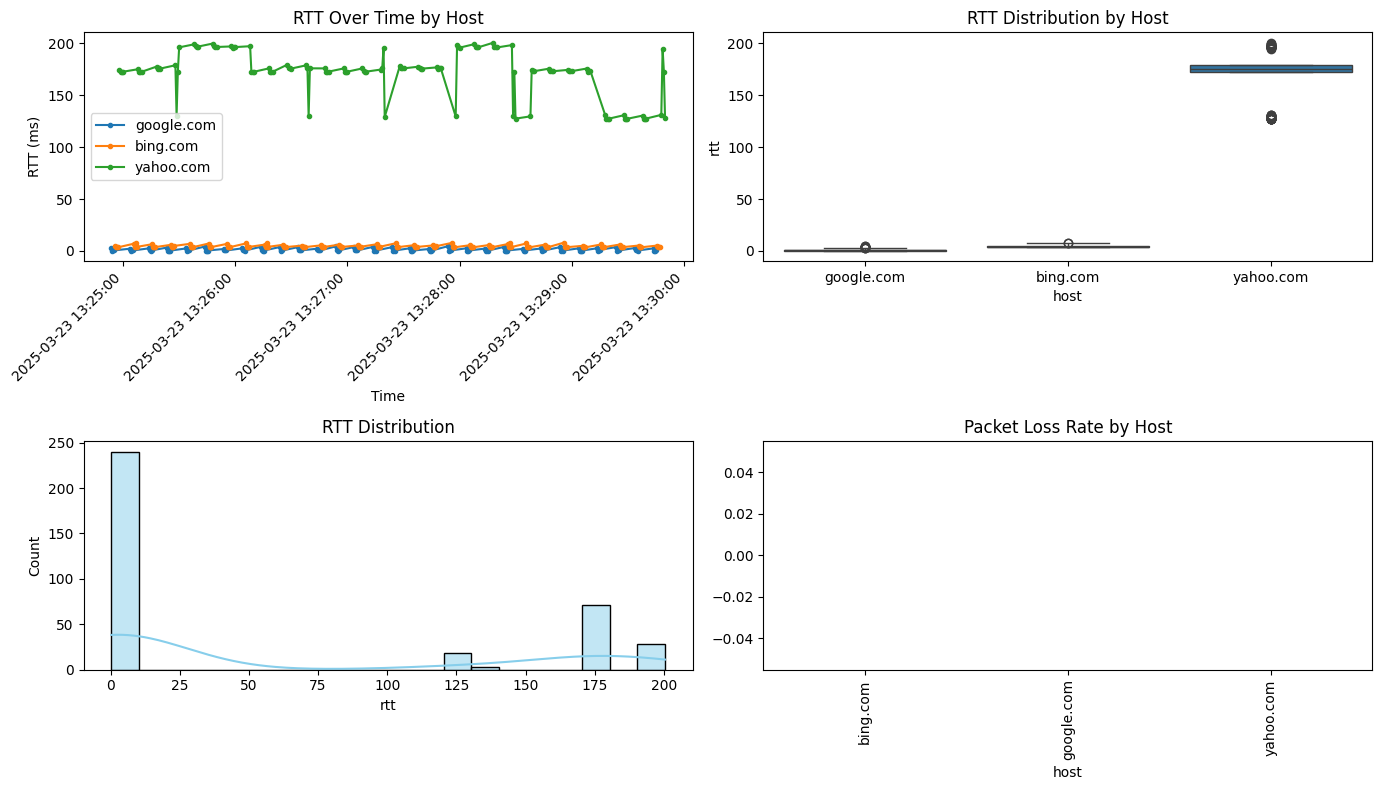

No model found at: rtt_model.joblib
Training a new model...

Model Evaluation:
  MSE: 234.32
  MAE: 6.93
  R-squared: 0.96

Feature Importances:
host_yahoo.com     0.999687
host_google.com    0.000313
dtype: float64

Sample Predictions:
       Actual   Predicted
0  129.492521  173.176304
1    3.468990    4.446701
2  172.946453  173.176304
3    0.358582    1.030561
4  198.940039  173.176304
Model --> rtt_model.joblib


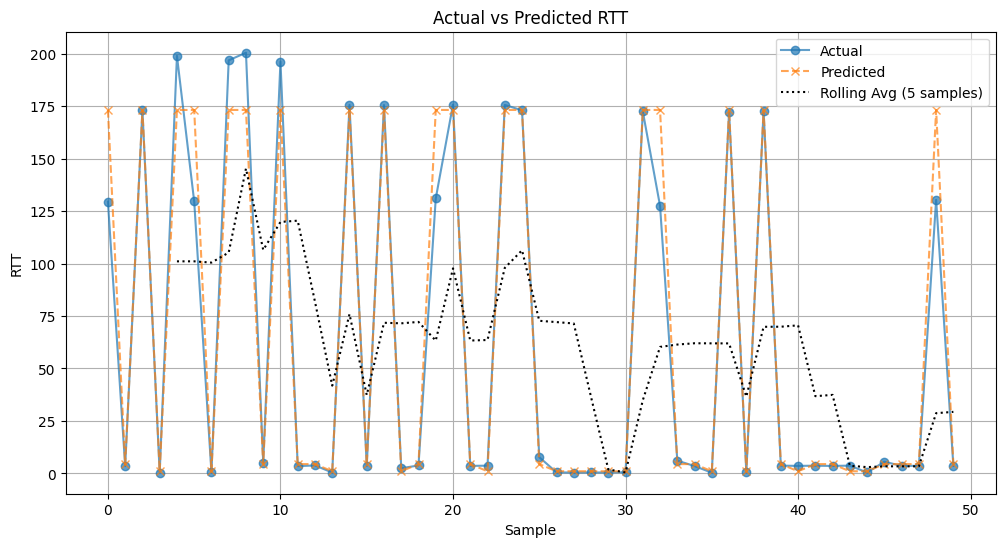

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from typing import Tuple
import matplotlib.dates as mdates  # For dates on the plot
import joblib  # Save/load
import os

def load_data(fpath: str) -> pd.DataFrame:
    """Load the CSV data.""" # Simple doc string
    df = pd.read_csv(fpath)
    df['time'] = pd.to_datetime(df['time']) # Convert time right away
    df_clean = df.dropna(subset=['rtt']) # Drop rows with no RTT

    # Check if we lost *all* the data...
    if df_clean.empty:
        raise ValueError("No RTT data after cleaning!  Check your input file.")
    return df_clean

def get_stats(data: pd.DataFrame) -> Tuple[pd.Series, pd.DataFrame, pd.Series]:
    """Calculate some descriptive stats"""
    rtt_stats = data['rtt'].describe()
    # Group by host
    host_stats = data.groupby('host')['rtt'].describe()
    # Packet loss rate
    loss_rate = data.groupby('host')['packet_loss'].mean() * 100
    return rtt_stats, host_stats, loss_rate



def make_plots(df: pd.DataFrame, rtt_stats: pd.Series, loss_rate: pd.Series):
    """Makes the plots, saves 'em."""  # More casual docstring

    plt.figure(figsize=(14, 8))

    # RTT over time, by host.  Use a list comprehension!
    plt.subplot(2, 2, 1)
    [plt.plot(df[df['host'] == h]['time'], df[df['host'] == h]['rtt'], label=h, marker='o', markersize=3, linestyle='-') for h in df['host'].unique()]
    plt.title('RTT Over Time by Host')
    plt.xlabel('Time')
    plt.ylabel('RTT (ms)')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S')) # Date formatting
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45, ha="right")
    plt.legend()

    # Box plots
    plt.subplot(2, 2, 2)
    sns.boxplot(x='host', y='rtt', data=df)
    plt.title('RTT Distribution by Host')

    # RTT histogram
    plt.subplot(2, 2, 3)
    sns.histplot(df['rtt'], kde=True, bins=20, color='skyblue') # Slightly different style
    plt.title('RTT Distribution')

    # Packet loss (if any...)
    plt.subplot(2, 2, 4)
    loss_rate.plot(kind='bar', color='coral') # Use the Series directly
    plt.title('Packet Loss Rate by Host')

    plt.tight_layout()
    plt.savefig('plot1.png')  # Save it!
    plt.show()

def prep_data(df: pd.DataFrame) -> pd.DataFrame:
    """One-hot encode the 'host' column."""
    # Use drop_first to avoid multicollinearity
    return pd.get_dummies(df, columns=['host'], drop_first=True)


def train_model(data: pd.DataFrame, test_size: float = 0.2,
                random_state: int = 42, n_est: int = 100,
                max_d: int | None = None) -> Tuple[RandomForestRegressor, pd.DataFrame]:
    """Trains the RandomForest model."""  # Simpler docstring

    # Features and target
    X = data.drop(columns=['time', 'rtt', 'packet_loss'])
    y = data['rtt']

    # Split the data.  Use short variable names here.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Create and train the model
    model = RandomForestRegressor(n_estimators=n_est, max_depth=max_d, random_state=random_state)
    model.fit(X_train, y_train)

    # Make predictions
    preds = model.predict(X_test)

    # Evaluate...
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)

    print("\nModel Evaluation:")
    print(f"  MSE: {mse:.2f}")  # Less verbose output
    print(f"  MAE: {mae:.2f}")
    print(f"  R-squared: {r2:.2f}")

    # Feature importances (print 'em)
    importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    print("\nFeature Importances:")
    print(importances)

    # Combine actual and predicted for comparison
    results_df = pd.DataFrame({'Actual': y_test, 'Predicted': preds}).reset_index(drop=True)
    print("\nSample Predictions:")
    print(results_df.head())

    return model, results_df

def plot_predictions(results_df: pd.DataFrame, n: int = 50, window: int = 5):
    """Plots actual vs. predicted, with a rolling average."""
    subset = results_df.head(n) # Just plot a subset

    plt.figure(figsize=(12, 6))
    plt.plot(subset['Actual'], label='Actual', marker='o', linestyle='-', alpha=0.7)
    plt.plot(subset['Predicted'], label='Predicted', marker='x', linestyle='--', alpha=0.7)

    # Rolling average for smoothing
    rolling = subset['Actual'].rolling(window=window).mean()
    plt.plot(rolling, label=f'Rolling Avg ({window} samples)', linestyle=':', color='black')

    plt.title('Actual vs Predicted RTT')
    plt.xlabel('Sample') # Shorter label
    plt.ylabel('RTT')
    plt.legend()
    plt.grid(True)
    plt.savefig('plot2.png')  # Save the plot
    plt.show()


def save_it(model: RandomForestRegressor, filename: str = "rtt_model.joblib"):
    """Save the model."""
    joblib.dump(model, filename)
    print(f"Model --> {filename}")  # More casual print

def load_it(filename: str = "rtt_model.joblib") -> RandomForestRegressor | None:
    """Load the model.  Returns None if it fails."""
    if os.path.exists(filename):
        model = joblib.load(filename)
        print(f"Loaded model from: {filename}")
        return model
    else:
        print(f"No model found at: {filename}")
        return None



def run_all(): # Less descriptive function name
    """Main function."""
    file_path = '/content/raw_ping_data.csv'
    model_file = "rtt_model.joblib"
    test_split_size = 0.2  #  Could make these command-line args... later.
    rand_state = 42
    n_estimators = 100
    max_depth = None

    # Load the data.  Handle errors.
    try:
        df = load_data(file_path)
    except FileNotFoundError:
        print(f"ERROR: File not found: {file_path}.  Run the data collection script first!")
        return  # Exit
    except ValueError as e:
        print(f"ERROR: {e}")
        return

    # Get stats and make plots
    rtt_stats, host_stats, loss_rate = get_stats(df)
    print("RTT Stats (Overall):")
    print(rtt_stats)
    print("\nRTT Stats (by Host):")
    print(host_stats)
    print("\nPacket Loss Rate (by Host):")
    print(loss_rate)
    make_plots(df, rtt_stats, loss_rate)


    # Prepare data (one-hot encoding)
    df_encoded = prep_data(df)

    # Load existing model, or train a new one
    model = load_it(model_file)
    if model is None:
        print("Training a new model...")
        model, results = train_model(df_encoded, test_split_size, rand_state, n_estimators, max_depth)
        save_it(model, model_file)  # Save the new model!
    else:
        # Even if we load the model, let's get predictions on a test set
      X = df_encoded.drop(columns=['time', 'rtt', 'packet_loss'])
      y = df_encoded['rtt']
      _, X_test, _, y_test = train_test_split(X, y, test_size=test_split_size, random_state=rand_state)
      preds = model.predict(X_test)
      results = pd.DataFrame({'Actual': y_test, 'Predicted': preds}).reset_index(drop=True)


    plot_predictions(results)


if __name__ == "__main__":
    run_all()